In [43]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
from konlpy.tag import Okt #형태소 분석
from nltk import bigrams
from nltk.util import ngrams
import pandas as pd

from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel # 토픽 개수 검증
from tqdm import tqdm
# from tqdm.notebook import tqdm
from gensim import corpora
from gensim.models import TfidfModel

import warnings
warnings.filterwarnings(action='ignore')

from modules import *

In [44]:
okt=Okt()

In [45]:
#원하는 태그 추출 & 불용어 제거
def okt_pos_tagging(string):
    
    #불용어
    stopwords = pd.read_csv('ko-stopwords.csv')
    stopwords=list(stopwords['stopwords'])
    stopwords.extend(['에서','고','이다','는','한','씨', "것","거","게","데","이다","건","고","되다","되어다","걸","기",
                      "시","네","듯","랍니","중이","얘","스","도도", "나","수","개","내","기","제","저","인","있다","이렇다",
                      "그렇다","번","위","팅","분","인","링","란","포","두", "진짜", "하다" ,"이다" ,"가다", "이제" ,"들다",
                     "너무", "먹다"])
    stopwords=set(stopwords)    
    pos_words = okt.pos(string, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Adjective', 'Verb'] if word not in stopwords ]
    return words


#bigram 만드는 함수
def bigram_(tokens):
    
    #document 별 형태소분석기로 분리된 토큰들을 bigram으로 변환(토큰은 string 상태)
    bigram_stack = [] #변환된 bigram
    for token in tokens:
        bigram = bigrams(token)
        bigram_token = [' '.join(grams) for grams in bigram]
        bigram_stack.append(bigram_token)
        
    #bigram  딕셔너리 생성(아이디 매칭)
    id2word = corpora.Dictionary(bigram_stack) #unigram
    #id2word.token2id  #아이디가 매칭된 딕셔너리 확인용

    #딕셔너리에 매칭한 corpus 생성
    #생성한 bigram 딕셔너리에서 bigram_stack의 토큰을 아이디로 매칭변환
    texts = bigram_stack 
    corpus = [id2word.doc2bow(text) for text in texts]
    
    #gensim으로 tf-idf 처리 #바이그램 요소 하나를 하나의 워드로 처리해서 tf_idf 점수
    tfidf = TfidfModel(corpus) 
    corpus_tfidf = tfidf[corpus]
    tfidf_corpus = [x for x in corpus_tfidf]
    return tfidf_corpus, corpus ,id2word


#perplexcity 계산(그래프 생성, 테이블 생성)
def perplexcity_graph(topic_n, bigram_result):
    #topic_n _ 몇개 토픽을 테스트 해볼것인지 지정    
    #perplexcity
    perplexity_value = []
    num_t = []
    for i in topic_n:
        model = LdaModel(bigram_result[0], num_topics = i, id2word=bigram_result[2])
        num_t.append(i)
        perplexity_value.append(model.log_perplexity(bigram_result[1]))

    #그래프
    plt.title('Perpelxity score')
    plt.plot(topic_n, perplexity_value)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity_scores')
    plt.show
    plt.savefig('Perplexity_Graph.png')  #그래프저장
    
    #테이블 저장
    perplexity_df = pd.DataFrame(list(zip(num_t,perplexity_value)), columns = ['cluster','perplexity_score'])
    perplexity_df.to_csv('Perplexity_score_table.csv', encoding='utf-8-sig')
    perplexity_df


#coherence 계산(그래프 생성, 테이블 생성)    
def coherence_graph(topic_n, bigram_result):
    coherence_value = []
    num_t = []

    for i in topic_n:
        model = LdaModel(bigram_result[0], num_topics = i, id2word=bigram_result[2])
        cm = CoherenceModel(model=model, corpus=bigram_result[1], coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_value.append(coherence)
        num_t.append(i)

    #그래프
    plt.title('Coherence score')
    plt.plot(topic_n, coherence_value)
    plt.xlabel('number of topics')
    plt.ylabel('coherence_scores')
    plt.show
    plt.savefig('Coherence_Graph.png')  #그래프저장

    #테이블 저장
    coherence_df = pd.DataFrame(list(zip(num_t,coherence_value)), columns = ['cluster','coherence_score'])
    coherence_df.to_csv('Coherence_score_table.csv', encoding='utf-8-sig')
    coherence_df

    
#doc 문서별 토픽 추출하기
def exctract_topic(ldamodel, corpus):
    topic_n = []
    topic_prop = []
    all_topic_prop = []
    for topic_doc in ldamodel[corpus]:
        topic_doc = sorted(topic_doc, key=lambda x: (x[1]), reverse=True) #여러 토픽이 할당되어 있는경우 높은 확률의 토픽순으로 정렬
        
        #확률 기준대로 정렬 했으므로 topic_doc[0] 제일 높은 확률의 토픽
        topic_n.append(int(topic_doc[0][0]))
        topic_prop.append(round(topic_doc[0][1],4))
        all_topic_prop.append(topic_doc)
        
    #데이터프레임화    
    data = {'topic':topic_n, 'topic_weight' : topic_prop ,'topic_all_weight': all_topic_prop}
    df = pd.DataFrame(data)
    return df

In [46]:
data = pd.read_csv('술 리뷰(전처리).csv')
text_data = data.reset_index(drop=True)
text_data

,Unnamed: 0,date,star,text,name
0,0,2022-10-31,5,지인으로부터 알게된 복순도가 막걸리처음 먹는순간 너무 맛있어서 깜짝놀랐어요원래 술을...,복순도가
1,1,2022-11-17,5,그냥 차게 마셔도 군내나 잔여물 찌꺼기 느낌이 거의 없이 깔끔담백하고 샴페인처럼 톡...,복순도가
2,2,2022-10-19,5,지인이 비싼데 고급지고 맛있는 막걸리가있다고 해서하도 궁금하여 한번 시켜봤어요배송도...,복순도가
3,3,2022-10-28,3,본인은 맛있었는데 아버지는 너무 삭힌거같다는 평이네요 새콤함이 좀 있긴함근데 막걸리...,복순도가
4,4,2022-10-13,5,복순도가 맛있다고 한참전에 소문만 들었지 먹어본것은 올해가 처음이네요 평소에도 달달...,복순도가
...,...,...,...,...,...
41842,41871,2022-01-09,5,비싸기도하고 병씩 사게되니 한번에 몰아먹어야해서 자주는 안사먹지만 막걸리땡길때 한번...,복순도가
41843,41872,2022-01-09,5,백스피릿보고 구매했어요 개는 배송비가 있어서 개 구매했어요오자마자 전복솥밥이랑 마셨...,복순도가
41844,41873,2022-01-09,5,선물하려구 재구매했어요,복순도가
41845,41874,2022-01-08,5,명절에 맛있게 잘 나눠먹었어요,복순도가


In [47]:
# # 사전에 클러스터링 한 결과가 있는 경우 활용
# # 클러스터를 돌아가며 결과를 도출할 경우 cluster 번호를 하나씩 변경
# text_data = data[data['클러스터']==1]
# text_data = text_data.reset_index(drop=True)

In [48]:
# del text_data['Unnamed: 0']
# text_data.head()

### 한국어 토큰화
- 한국어 토큰을 완료한 후에 bigram과 tf-idf 점수를 기준으로 딕셔너리를 만들어 LDA에 적용될 수 있게 맵핑하는 작업

In [49]:
text_data = text_data.dropna(axis=0)
text_data

,Unnamed: 0,date,star,text,name
0,0,2022-10-31,5,지인으로부터 알게된 복순도가 막걸리처음 먹는순간 너무 맛있어서 깜짝놀랐어요원래 술을...,복순도가
1,1,2022-11-17,5,그냥 차게 마셔도 군내나 잔여물 찌꺼기 느낌이 거의 없이 깔끔담백하고 샴페인처럼 톡...,복순도가
2,2,2022-10-19,5,지인이 비싼데 고급지고 맛있는 막걸리가있다고 해서하도 궁금하여 한번 시켜봤어요배송도...,복순도가
3,3,2022-10-28,3,본인은 맛있었는데 아버지는 너무 삭힌거같다는 평이네요 새콤함이 좀 있긴함근데 막걸리...,복순도가
4,4,2022-10-13,5,복순도가 맛있다고 한참전에 소문만 들었지 먹어본것은 올해가 처음이네요 평소에도 달달...,복순도가
...,...,...,...,...,...
41842,41871,2022-01-09,5,비싸기도하고 병씩 사게되니 한번에 몰아먹어야해서 자주는 안사먹지만 막걸리땡길때 한번...,복순도가
41843,41872,2022-01-09,5,백스피릿보고 구매했어요 개는 배송비가 있어서 개 구매했어요오자마자 전복솥밥이랑 마셨...,복순도가
41844,41873,2022-01-09,5,선물하려구 재구매했어요,복순도가
41845,41874,2022-01-08,5,명절에 맛있게 잘 나눠먹었어요,복순도가


In [50]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41847 entries, 0 to 41846
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41847 non-null  int64 
 1   date        41847 non-null  object
 2   star        41847 non-null  int64 
 3   text        41847 non-null  object
 4   name        41847 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [51]:
# 원문 데이터를 한국어 형태소 기준으로 토큰화 진행
# 기본 셋팅되어 있는 형태소는 명사, 형용사, 동사 입니다
# 형태소 변경이 필요할 경우 module.py 파일에서 변경
tokenizing_sent = []
for i in tqdm(text_data['text']):
    tokenizing_sent.append(okt_pos_tagging(i))
text_data['tokenizing'] = tokenizing_sent
text_data   # 토큰화된 결과값을 기존의 원문 파일 테이블에 추가

100%|██████████| 41847/41847 [10:46<00:00, 64.73it/s] 


,Unnamed: 0,date,star,text,name,tokenizing
0,0,2022-10-31,5,지인으로부터 알게된 복순도가 막걸리처음 먹는순간 너무 맛있어서 깜짝놀랐어요원래 술을...,복순도가,"[지인, 알, 복, 순도, 막걸리, 처음, 순간, 맛있다, 깜짝, 원래, 술, 좋아..."
1,1,2022-11-17,5,그냥 차게 마셔도 군내나 잔여물 찌꺼기 느낌이 거의 없이 깔끔담백하고 샴페인처럼 톡...,복순도가,"[그냥, 차다, 마시다, 군내, 잔, 여물, 찌꺼기, 느낌, 깔다, 끄다, 담백하다..."
2,2,2022-10-19,5,지인이 비싼데 고급지고 맛있는 막걸리가있다고 해서하도 궁금하여 한번 시켜봤어요배송도...,복순도가,"[지인, 비싸다, 고급, 지고, 맛있다, 막걸리, 궁금하다, 한번, 보다, 배송, ..."
3,3,2022-10-28,3,본인은 맛있었는데 아버지는 너무 삭힌거같다는 평이네요 새콤함이 좀 있긴함근데 막걸리...,복순도가,"[본인, 맛있다, 아버지, 삭히다, 평이, 콤함, 함, 막걸리, 맛있다, 숙성, 콤함임]"
4,4,2022-10-13,5,복순도가 맛있다고 한참전에 소문만 들었지 먹어본것은 올해가 처음이네요 평소에도 달달...,복순도가,"[복, 순도, 맛있다, 참전, 소문, 보다, 올해, 처음, 요, 평소, 달달, 콤,..."
...,...,...,...,...,...,...
41842,41871,2022-01-09,5,비싸기도하고 병씩 사게되니 한번에 몰아먹어야해서 자주는 안사먹지만 막걸리땡길때 한번...,복순도가,"[비싸다, 기도, 병, 사다, 한번, 몰다, 야하다, 자주, 사먹다, 막걸리, 땡기..."
41843,41872,2022-01-09,5,백스피릿보고 구매했어요 개는 배송비가 있어서 개 구매했어요오자마자 전복솥밥이랑 마셨...,복순도가,"[스피릿, 보고, 구매, 개다, 배송비, 구매, 전복, 솥밥, 마시다, 평소, 막걸..."
41844,41873,2022-01-09,5,선물하려구 재구매했어요,복순도가,"[선물, 재다]"
41845,41874,2022-01-08,5,명절에 맛있게 잘 나눠먹었어요,복순도가,"[명절, 맛있다, 자다, 나누다]"


In [52]:
# bigram을 적용하여 tf-idf 기준으로 토큰과 맵핑
# 데이터프레임 형태의 tokenizing 된 단어들을 bigram 형태로 변환하기 위한 작업

texts = text_data['tokenizing']
bigram_result = bigram_(texts)

bigram_result

([[(0, 0.1549165752084189),
   (1, 0.1549165752084189),
   (2, 0.08876048625687451),
   (3, 0.14412312860648357),
   (4, 0.1549165752084189),
   (5, 0.14064841490465405),
   (6, 0.1549165752084189),
   (7, 0.11558680799895396),
   (8, 0.12985496830271875),
   (9, 0.06531481931170567),
   (10, 0.14860281369275055),
   (11, 0.1030286465606393),
   (12, 0.1549165752084189),
   (13, 0.14860281369275055),
   (14, 0.09103164091273765),
   (15, 0.10788357033141747),
   (16, 0.14064841490465405),
   (17, 0.10788357033141747),
   (18, 0.14412312860648357),
   (19, 0.11223716847868856),
   (20, 0.13332968200454828),
   (21, 0.051220368479808154),
   (22, 0.043452747403469834),
   (23, 0.14412312860648357),
   (24, 0.1549165752084189),
   (25, 0.1207021589732116),
   (26, 0.13332968200454828),
   (27, 0.1549165752084189),
   (28, 0.07536145426348821),
   (29, 0.08944256544863599),
   (30, 0.14860281369275055),
   (31, 0.1549165752084189),
   (32, 0.09806979591763691),
   (33, 0.1270159204888799),

### LDA 토픽 갯수 테스트
#### perplexcity score & coherence score
- 적절한 Elbow point와 클러스터링된 원문을 보고 적절할 토픽 갯수를 선정
- check_topic_n 변수에 테스트해볼 토픽의 갯수를 입력
- 토픽의 갯수는 range를 사용해서 입력

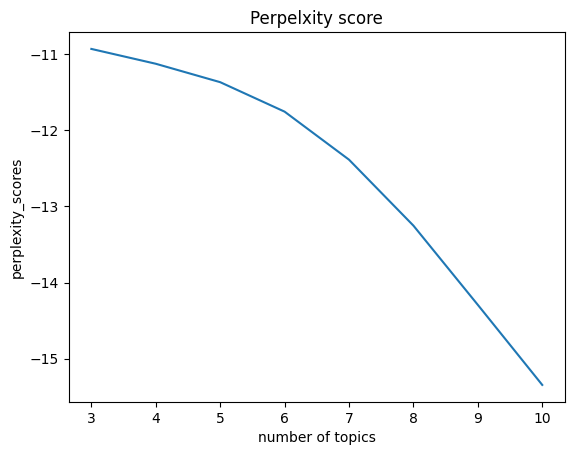

In [53]:
check_topic_n = range(3,11)

# perplexcity score : 복잡도 -> 낮을수록 좋음
perplexcity_graph(check_topic_n, bigram_result)

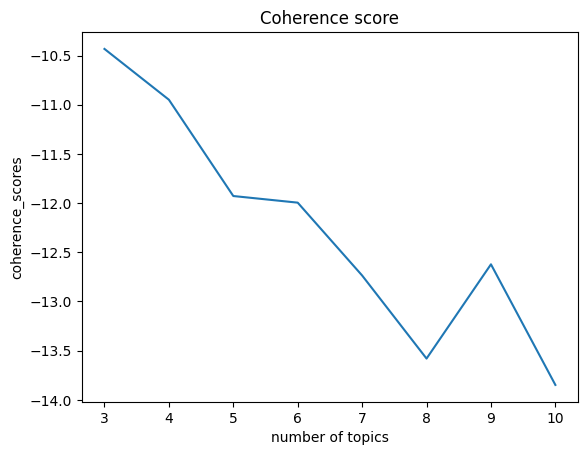

In [54]:
# coherence score : 일관성 -> 높을수록 좋음
# perplexcity와 coherence는 완벽한 정답이 아니므로 추가 판단 필요

# 토픽의 갯수에 따라 달라지는 coherence 점수를 보여줌
# png와 csv파일로 저장됨
coherence_graph(check_topic_n, bigram_result)

### LDA 시각화
- pyLDAvis Lib를 활용해 LDA를 시각화
- 토픽별 할당된 documents 확인

In [55]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

### 라이브러리 테스트
- pyLDAvis 라이브러리 테스트 -> lda시각화가 잘 실행되는지 확인
- 오류나면 라이브러리 설치가 제대로 되었는지 확인

In [56]:
model = LdaModel(bigram_result[0], num_topics=5, id2word=bigram_result[2])
visual = gensimvis.prepare(model, bigram_result[1], bigram_result[2])
pyLDAvis.display(visual)

### LDA시각화 실행 및 저장
- check_topic_n에서 설정했던 토픽의 갯수별로 시각화된 LDA가 저장
- 저장된 파일은 html 확장자
- topic 개수를 새로 정하고 싶으면 check_topic_n 대신 range(n,m)을 넣어주면 됨
- 시각화 파일과 함께 대조하여 원문을 확인할 수 있도록 토픽 개수에 따른 원문도 저장됨

#### 토픽 할당, 할당된 document 추출(원문 검토시 활용)
- document 별로 해당하는 document가 몇 번 토픽에 할당되었는지를 보여줌
- topic_weight 컬럼은 topic 컬럼에서의 해당 토픽일 확률
- topic_all_weight 컬럼은 설정한 모든 토픽에 대하여 해당 document가 각 토픽에 할당될 확률


In [57]:
for i in tqdm(check_topic_n):
    # lda 시각화된 결과 저장
    model = LdaModel(bigram_result[0], num_topics=i, id2word=bigram_result[2])
    visual = gensimvis.prepare(model, bigram_result[1], bigram_result[2])
    pyLDAvis.save_html(visual, 'LDA토픽추출_시각화_topic_n{}(막걸리).html'.format(i))

    # lda 데이터프레임 저장(원문, 토픽 넘버 매칭)
    lda_result = exctract_topic(model, bigram_result[1])
    df = pd.concat([text_data, lda_result], axis=1)
    df.to_csv('LDA토픽추출_원문_topic_n{}(막걸리).csv'.format(i), encoding='utf-8-sig')
    

100%|██████████| 8/8 [01:28<00:00, 11.11s/it]
